# Clase 18: Sistemas de Recomendación

**MDS720: Laboratorio de Programación Científica para Ciencia de Datos**


## Objetivos de la clase

- Introducir al estudiante a los sistemas de recomendación
- Diferenciar entre los principales tipos de sistemas de recomendación, sus ventajas y desventajas
- Aprender a implementar sistemas de recomendación basados en contenido usando técnicas de NLP
- Aprender a implementar sistemas de recomendación basados en filtros colaborativos usando `surprise`

## Dataset a ocupar

Para esta clase ocuparemos datos basados en el dataset de [TMDB 5000 Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv), el cual contiene calificaciones de películas realizadas por usuarios. De esta forma, la idea de esta clase es que podamos usar este dataset para entrenar diferentes sistemas de recomendación y así entender el funcionamiento de estos modelos.

<div style="text-align: center;">
    <img src="https://storage.googleapis.com/kaggle-datasets-images/138/287/229bfb5d3dd1a49cc5ac899c45ca2213/dataset-cover.png" style="width: 50%;">
</div>


In [1]:
import pandas as pd

df = pd.read_parquet('https://raw.githubusercontent.com/MDS7202/MDS7202/main/recursos/2024-01/recommendations/movies.parquet')
df

,userId,movieId,rating,title,overview
0,1,1371,2.5,Rocky III,"Now the world champion, Rocky Balboa is living..."
1,4,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
2,7,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
3,19,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
4,21,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
...,...,...,...,...,...
44847,652,129009,4.0,Love Is a Ball,Etienne makes a good living out of marrying of...
44848,653,2103,3.0,Solaris,Upon arrival at the space station orbiting an ...
44849,659,167,4.0,K-PAX,Prot is a patient at a mental hospital who cla...
44850,659,563,3.0,Starship Troopers,"Set in the future, the story follows a young s..."


In [2]:
df.loc[df['title'] == 'The Matrix', 'overview'].values[0]

'Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.'

## ¿Qué son los Sistemas de Recomendación?

Un **sistema de recomendación** es un algoritmo de machine learning, típicamente ligado a servicios digitales, que utiliza grandes volúmenes de datos para sugerir o **recomendar productos adicionales** a los consumidores. Estas recomendaciones se basan en una variedad de criterios, como compras previas, historial de búsquedas, información demográfica, entre otros. Los sistemas de recomendación son extremadamente útiles pues **permiten a los usuarios descubrir productos y servicios que quizás no habrían encontrado por sí mismos**, ayudando a filtrar y priorizar las alternativas más adecuadas a sus gustos y necesidades.

Los sistemas de recomendación son entrenados para **generar recomendaciones personalizadas a usuarios**, distinguiendo por sus preferencias, decisiones y  características tanto de los usuarios como de los productos. El tipo de input que usan para generar estas recomendaciones es lo que diferencia un sistema de otro. Por ejemplo, los sistemas de recomendación del tipo **Filtros Colaborativos** son entrenados para resolver este problema a partir de **interacciones usuario-producto**. Estas interacciones pueden ser:
- Ratings de películas
- Clicks sobre un producto
- Cantidad de productos comprada por un usuario
- Likes a un contenido en una red social
- Cantidad de tiempo que usuario pasa sobre un catálogo
- Entre muchas, muchas otras

> **Pregunta:** ¿Qué otras interacciones se les ocurre?

Por ejemplo, las recomendaciones de estos sistemas podrían ser vistas de esta manera:

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*MLr8crqbUC9MazNIGOZOzw.png" style="width: 50%;">
</div>

<center><i>Ejemplo de recomendaciones hechas a partir de un sistema de recomendación</i></center>

<br></br>
> **Pregunta**: ¿Han visto este tipo de anuncios antes? ¿Dónde?

## Objetivo del Sistema de Recomendación

<div style="text-align: center;">
    <img src="https://i.giphy.com/guufsF0Az3Lpu.webp" style="width: 30%;">
</div>

El objetivo principal de un sistema de recomendación es **impulsar las ventas** al facilitar que los usuarios descubran productos que, de otro modo, podrían pasar desapercibidos. De hecho, estos sistemas surgieron como una herramienta estratégica para aumentar la rentabilidad de los comercios. Al presentar a cada usuario una selección personalizada de artículos relevantes, los sistemas de recomendación no solo mejoran la experiencia del usuario, sino que también **incrementan la probabilidad de compra**, generando así mayores ingresos para el vendedor.

A su vez, los sistemas de recomendación fundamentan su funcionamiento en torno a tres componentes:

- **Usuarios o *Users***
- **Productos o *Items***
- **Calificaciones o *Ratings***

Teniendo esto en consideración, el **problema de recomendación** puede ser formulado de dos maneras:

- **Problema de regresión:** Este enfoque se centra en **predecir el valor de calificación para una combinación específica de usuario y artículo**. Partimos de la base de que existen datos de entrenamiento que reflejan las preferencias de los usuarios por ciertos artículos. Con *m* usuarios y *n* productos, esto se traduce en una matriz *m* × *n* incompleta, donde los valores conocidos son usados para el entrenamiento del modelo. De esta manera, los **valores faltantes son predichos usando el sistema de recomendación**. Este problema es también conocido como el problema de *matrix completion*, en el cual se especifica una matriz de manera incompleta y los valores restantes son inferidos por el algoritmo de aprendizaje.

<div style="text-align: center;">
    <img src="https://www.researchgate.net/profile/Mehdi-Elahi-2/publication/332511384/figure/fig1/AS:749057106513920@1555600539326/Rating-Matrix-rows-represent-users-and-columns-represent-items-The-entries-of-the.jpg" style="width: 50%;">
</div>

- **Problema de clasificación:** En contextos prácticos, no siempre es necesario predecir las calificaciones de los usuarios para artículos específicos a fin de hacer recomendaciones. En cambio, podría ser más útil para un comerciante **recomendar los *k* mejores artículos para un usuario específico**, o de manera equivalente, **identificar los *k* mejores usuarios a los que dirigir un artículo particular**. La identificación de artículos top-k es más habitual que la de usuarios top-k, aunque los métodos utilizados en ambos casos son esencialmente los mismos. Este problema también se denomina *top-k recommendation problem* y constituye la formulación de clasificación del problema de recomendaciones.

En el segundo caso, los valores absolutos de las calificaciones predichas no son relevantes. La primera formulación es más general, ya que las soluciones al segundo caso pueden obtenerse obteniendo las calificaciones predichas por el modelo. No obstante, en muchas situaciones resulta más sencillo y práctico diseñar métodos que aborden directamente la versión de clasificación del problema.

> **Pregunta**: ¿Cual de las dos formulaciones podría ser más atingente para las necesidades de una empresa? Porqué?

## ¿Qué propiedades debe cumplir una buena recomendación?

<div style="text-align: center;">
    <img src="https://i.giphy.com/ApdE3t6VqYQz8yAIOa.webp" width="450">
</div>


En orden para cumplir con el objetivo de incrementar el *engagement* del usuario con los productos, las recomendaciones generadas deben cumplir con las siguientes características:

- **Relevancia:** El objetivo operacional más evidente de un sistema de recomendación es **sugerir artículos que resulten pertinentes para el usuario**. Los usuarios son más propensos a consumir artículos que les resultan interesantes. Recomendar productos relevantes constituye el objetivo principal de un sistema de recomendación, aunque no es suficiente por sí misma para generar un sistema exitoso.

- **Novedad:** Los sistemas de recomendación son exitosos cuando el producto recomendado es algo que el usuario **no ha visto en el pasado**. Por ejemplo, películas populares del género favorito por el usuario rara vez representan una novedad. Además, la recomendación reiterada de artículos populares puede resultar en una disminución de la diversidad de ventas.

- **Diversidad:** Los sistemas de recomendación tipicamente sugieren una lista de top-k items. Cuando todas las recomendaciones son similares, incrementa el riesgo que el usuario pueda no elegir ninguna recomendación. Por otro lado, si la **lista de recomendaciones posee productos de diferentes tipos**, existe una **mayor probabilidad de que el usuario pueda gustarle al menos uno de esos productos**. La diversidad en las recomendaciones tiene el beneficio de asegurar que el usuario no se aburra por recomendaciones de productos similares.

- **Serendipia:** También llamado *casualidad*, se refiere a que las recomendaciones son algo **inesperadas** y, por ende, conllevan un elemento de descubrimiento fortuito, a diferencia de las recomendaciones más previsibles. La serendipia se distingue de la novedad porque implica recomendaciones que resultan verdaderamente sorprendentes para el usuario, más allá de ser meramente algo desconocido para ellos anteriormente. Es común que algunos usuarios consuman exclusivamente artículos de un tipo específico, aunque puedan tener **intereses latentes en otros tipos de artículos**, cuyo descubrimiento resultaría sorprendente para ellos. A diferencia de la novedad, los métodos serendípicos se enfocan en **descubrir estas recomendaciones inesperadas**.

## Tipos de Sistemas de Recomendación

> **Discusión:** Supongan que cuentan con una tabla con las ventas históricas de una tienda de libros. ¿Qué harían ustedes para recomendar productos?

Si bien existe un gran número de tipos de sistemas de recomendación, en esta clase nos centraremos en dos categorías principales: **Métodos Basados en Contenido** y **Filtros Colaborativos**. Conozcamos en detalle cada uno de estos:

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*L3RyKloSo-mTAezwlarVcg.png" width="500">
</div>

### Métodos Basados en Contenido

En contraste con los filtros colaborativos, los métodos basados en contenido aprovechan **información sobre los usuarios y/o los productos**. Por ejemplo, en un sistema de recomendación de películas, esta información podría incluir la edad, el sexo, la profesión y otros datos personales de los usuarios, así como la categoría, los actores principales, la duración y otras características relevantes de las películas.

La esencia de los métodos basados en contenido radica en **desarrollar un modelo que utilice las características disponibles** para explicar las interacciones observadas entre usuarios y artículos. De esta manera, **la principal diferencia con los filtros colaborativos es que los métodos basados en contenido no usan las interacciones como feature**, sino que intentan "explicar" las interacciones a partir de las características de los usuarios y/o productos. Tomando en cuenta el ejemplo de las películas, se podría intentar modelar cómo, por ejemplo, las mujeres jóvenes tienden a valorar mejor ciertas películas, mientras que los hombres jóvenes prefieren otras. Si conseguimos establecer un modelo efectivo, realizar nuevas predicciones para un usuario resulta sencillo: basta con examinar el perfil del usuario (edad, sexo, etc.) y, con base en esa información, identificar las películas que podrían ser de su interés.

La **principal ventaja** de este tipo de métodos es con respecto al problema de **Coldstart**, es decir, **predecir para nuevos usuarios y/o productos**. Por ejemplo, si un nuevo usuario es registrado junto a sus datos demográficos (sexo, edad, residencia, etc.) es posible generar un set de recomendaciones sólo en función de estas características. Sólo los nuevos usuarios o artículos con características completamente nuevas tendrán problemas en la predicción (ejemplo: sistema que no se entrenó con personas de la tercera edad), aunque a medida que el sistema madura, la probabilidad de que esto ocurra es cada vez menor.

<div style="text-align: center;">
    <img src="https://i0.wp.com/spotintelligence.com/wp-content/uploads/2023/11/content-based-recommendation-system-1024x576.webp?resize=1024%2C576&ssl=1" width=650>
</div>


### Implementación

En esta sección implementaremos un sistema de recomendación basado en contenido de producto usando el resumen de la película (del tipo `string`) para generar recomendaciones.

**Recuerden que un sistema de recomendación basado en contenido puede construirse usando features de usuarios y/o productos.** Si bien en esta sección nos basaremos únicamente en características de la película, perfectamente podríamos entrenar un sistema de recomendación usando características del usuario (edad, sexo, etc).

Recordemos el formato de los datos disponibles:

In [3]:
df.head()

,userId,movieId,rating,title,overview
0,1,1371,2.5,Rocky III,"Now the world champion, Rocky Balboa is living..."
1,4,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
2,7,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
3,19,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
4,21,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."


Noten como los datos contienen múltiples calificaciones para cada película. Recordando que este tipo de modelo **no necesita de las interacciones usuario-producto**, es posible entonces reducir la dimensionalidad de nuestro dataset a 1 fila por películas agrupando:

In [4]:
# agrupamos datos por producto
df_bow = df.groupby('movieId')[['title', 'overview']].first().reset_index() # solo nos quedamos con atributos de productos
df_bow

,movieId,title,overview
0,2,Ariel,Taisto Kasurinen is a Finnish coal miner whose...
1,3,Shadows in Paradise,"An episode in the life of Nikander, a garbage ..."
2,5,Four Rooms,It's Ted the Bellhop's first night on the job....
3,6,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
4,11,Star Wars,Princess Leia is captured and held hostage by ...
...,...,...,...
2804,140174,Rise of the Zombies,"When zombies overrun San Francisco, a desperat..."
2805,142507,Exit,Several people think the city is a maze and th...
2806,148652,The Eleventh Victim,Nancy Grace's THE ELEVENTH VICTIM is a taut su...
2807,158238,Stolen Seas,Stolen Seas presents a chilling exploration of...


Habiendo preparado nuestro dataset, podemos ahora procesar nuestro dataset para generar recomendaciones basadas en contenido de producto. Noten que para este caso, tenemos 2 atributos del tipo string por cada película: `title` y `overview`. ¿Cómo podemos procesar este tipo de feature?

#### Bag of Words

`Bag of Words` es un modelo de conteo utilizado en Procesamiento de Lenguaje Natural (NLP) que tiene como objetivo **generar una representación vectorial** (vector de características en nuestro cas) para cada documento a través del conteo de las palabras que contienen.

La siguiente figura muestra un ejemplo de `Bag of Words` en acción:

<p align="center">
  <img src="https://user.oc-static.com/upload/2020/10/23/16034397439042_surfin%20bird%20bow.png" width="500">
</p>

> **Pregunta:** ¿Conocen otros métodos para vectorizar texto? ¿Cuáles?

Podemos implementar fácilmente este método a través de `sklearn`:

```python
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit_transform(text)
```

Probemos ahora a procesar la columna `overview` usando `Bag of Words`:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # instanciamos BoW
bow = vectorizer.fit_transform(df_bow['overview']).toarray() # Vectorizamos texto
bow = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out()) # Transformamos a Dataframe
bow

,00,000,007,04,05pm,10,100,1000,101,108,...,äventyr,ébats,échecs,éclats,émigré,émile,étienne,étrange,ömer,łódź
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Noten como a partir de una columna de texto, se generan 17435 columnas (1 por cada palabra distinta contenida en `overview`).

Un problema típico de esta metodología es el incremento explosivo de la dimensionalidad de los datos. Para atacar esto, un método efectivo es **limpiar el texto de entrada** aplicando técnicas de procesamiento de texto. En específico, implementaremos:
- Transformación de palabras a minúsculas
- Filtrar a todas las palabras que aparezcan en 10 documentos como mínimo
- Eliminación de *stopwords* en inglés

Nuevamente, podemos implementar lo anterior de manera sencilla usando `sklearn`:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase = True, # transformación a minúsculas
                             min_df = 10, # mínimo 10 ocurrencias
                             stop_words = 'english') # eliminar stopwords
bow = vectorizer.fit_transform(df_bow['overview']).toarray() # Vectorizamos texto
bow = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out()) # Transformamos a Dataframe
bow

,000,10,11,12,13,15,17,18,1950s,1960s,...,writing,written,wrong,yard,year,years,york,young,younger,youth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2807,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Observen como el número de features se redujo desde 17435 a 1472 (sólo 10% de lo que era originalmente!)

> **Pregunta:** ¿Como sería el resultado si además tengo otra columna de texto a procesar? ¿Y si además tengo columnas numéricas?

#### Buscando películas con mayor similitud

Con los datos vectorizados, podemos ahora encontrar las películas que guardan una mayor relación entre sí a través de la **similitud coseno**. Este método calcula la similitud entre dos vectores y es calculada de la siguiente forma:

$$\cos(\theta) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|}$$


donde $\cos(\theta)$ varía entre los valores (-1, 1) y (a,b) representa el par de vectores a calcular la similitud. Una similitud coseno igual a 1 indica que ambos vectores son idénticos, mientras que una similitud igual a -1 indica que los vectores son opuestos.

Si consideramos que $a$ y $b$ son los vectores generados anteriormente por BoW, podemos interpretar el resultado de esta operación como el **grado de similaridad de palabras clave entre dos descripciones de película (`overview`)**.

<div style="text-align: center;">
    <img src="https://dinispeixoto.com/img/posts/brand-recommendations-tfidf/cosine_similarity.png" width=400>
</div>

**Pregunta:** ¿Conocen otras formas para medir la similitud entre dos vectores?

Algunas medidas de similitud interesantes: [Métricas de Similitud.](https://scikit-learn.org/stable/modules/metrics.html)

Veamos ahora como implementar la similitud coseno usando `sklearn`:

In [7]:
# importamos cosine_similarity de sklearn
from sklearn.metrics.pairwise import cosine_similarity

# calculamos la similitud coseno de cada vector generado contra el resto
cosine_sim = cosine_similarity(bow, bow)
cosine_sim

array([[1.        , 0.09365858, 0.        , ..., 0.12373764, 0.        ,
        0.08240856],
       [0.09365858, 1.        , 0.        , ..., 0.        , 0.06537205,
        0.07332356],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.12373764, 0.        , 0.        , ..., 1.        , 0.04318335,
        0.04843595],
       [0.        , 0.06537205, 0.        , ..., 0.04318335, 1.        ,
        0.02875987],
       [0.08240856, 0.07332356, 0.        , ..., 0.04843595, 0.02875987,
        1.        ]])

In [8]:
cosine_sim.shape

(2809, 2809)

Noten como el resultado es una matriz de N x N, donde cada valor de la matriz puede ser interpretado como la similitud coseno entre dos descripciones de películas. Esta matriz comparte las mismas propiedades que la matriz de correlación: es **simétrica** y la **diagonal representa la similitud coseno de la película consigo misma** (similitud = 1).

Con la similitud calculada, generemos 5 recomendaciones de película para un usuario con gustos relacionados a *Rocky*:

In [10]:
def get_recommendations(df, movie, k = 5):

  """
  Returns the top k similar movies using BoW
  """

  # Assert movie is contained in dataset
  assert movie in df['title'].values, 'movie is not contained in train dataset!'

  # Get idx of movie
  idx = df[df['title'] == movie].index[0]

  # Get pairwise similarities of all movies with specified movie
  sim_scores = list(enumerate(cosine_sim[idx]))

  # Sort the movies based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

  # Get the scores of the k most similar movies
  sim_scores = sim_scores[1:k+1]

  # Get the movie indices
  movie_indices = [i[0] for i in sim_scores]

  # Return the top k most similar movies
  return df['title'].iloc[movie_indices].values

get_recommendations(df = df_bow, movie = 'Rocky')

array(['Rocky IV', 'Rocky Balboa', 'Rocky V', 'Rocky II', 'Dog Eat Dog'],
      dtype=object)

Veamos ahora como generar recomendaciones para un usuario en específico:

In [11]:
# primero rescatamos la película más vista por el usuario
userId = 33 # usuario a recomendar
user_movies = df[df['userId'] == userId].sort_values('rating', ascending = False) # películas rateadas por el usuario
best_movie = user_movies.iloc[0]['title'] # película con mejor rating
print(f'most liked movie by user {userId}: {best_movie}')

most liked movie by user 33: The Most Dangerous Game


In [12]:
# finalmente, printeamos las k mejores recomendaciones para el usuario
get_recommendations(df = df_bow, movie = best_movie)

array(['Masques', 'Hitman', 'Catwoman', 'Judgment Night', 'Far Cry'],
      dtype=object)

> **Pregunta:** Habíamos dicho que el entrenamiento de este tipo de modelos no necesitaba interacciones de usuario-producto. Si es así, ¿porqué necesitamos saber la película mas vista por el usuario?

## Filtros Colaborativos

Los métodos colaborativos para sistemas de recomendación **se basan únicamente en las interacciones pasadas registradas entre usuarios y artículos** para producir nuevas recomendaciones. Estas interacciones se almacenan en la **matriz de interacciones usuario-producto**, la cual sigue la siguiente forma:

<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*swlCZkfOdnxKJnQ1xHjIkw.png" style="width: 25%;">
</div>

La **principal ventaja** de los enfoques colaborativos es que usa la **totalidad de la matriz usuario-producto para generar recomendaciones**. En otras palabras, las **recomendaciones son generadas en base a interacciones de usuarios similares**, entregando un mayor potencial al modelo. Además, estos modelos **no requieren información sobre los usuarios o los artículos**, por lo que pueden utilizarse en muchas situaciones. Finalmente y como consecuencia de todo lo anterior, **cuanto más interactúan los usuarios con los artículos, más precisas son las recomendaciones**, lo que es deseable cuando se disponen grandes volúmenes de datos.

### ¿Cómo funciona?

La idea central de los Filtros Colaborativos es recomendar en base a usuarios que tienen un **perfil de interacciones** similar. La idea es simple: Si dos usuarios tienen un **comportamiento de compra similar** (tienen gustos parecidos en películas, música, libros, etc), la **probabilidad de que a ambos usuarios les guste el mismo producto es alta**. Si lo anterior es verdad, entonces una buena recomendación sería **todos aquellos productos que son del gusto de un usuario que no son "consumidos" por el otro usuario**.

<div style="text-align: center;">
    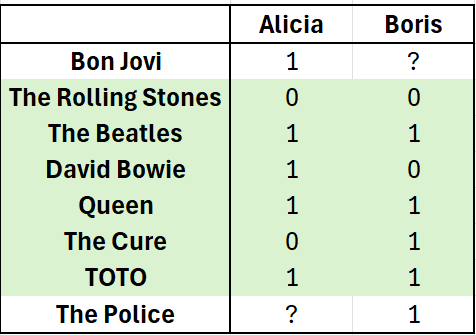
</div>

<div style="text-align: center;">
    <img src="https://editor.analyticsvidhya.com/uploads/460031_9XZYM6B5Ly-ENYTkEtr9dA.png" width=400>
</div>


### Coldstart
Dado que solo considera interacciones pasadas para hacer recomendaciones, el filtrado colaborativo sufre del problema de **Coldstart** (es decir, **no puede generar recomendaciones a usuarios nuevos**). Este inconveniente puede abordarse de diferentes maneras:
- Recomendando **artículos aleatorios** a nuevos usuarios o nuevos artículos a usuarios aleatorios (estrategia aleatoria)
- Recomendando **artículos populares** a nuevos usuarios o nuevos artículos a los usuarios más activos (estrategia de máxima expectativa)
- Recomendando un **conjunto de diversos artículos** a nuevos usuarios o un nuevo artículo a un conjunto de diversos usuarios (estrategia exploratoria)
- Utilizando un **método no colaborativo durante la primera etapa** de vida del usuario o del artículo.

Finalmente, los filtros colaborativos se pueden clasificar en dos categorías:
- **Basados en memoria**: Trabajan directamente sobre los valores registrados en la matriz usuario-producto y se basan principalemente en la búsqueda de vecinos cercanos (por ejemplo, usando `KNN`).
- **Basados en modelo**: Asumen que existe un proceso generativo que explica las interacciones usuario-producto el cual intentan modelar para generar predicciones.

Conociendo lo básico de Filtros Colaborativos, veamos ahora en detalle uno de estos modelos:

### NMF

**Non-negative Matrix Factorization (NMF)** es un modelo perteneciente a la familia de **filtros colaborativos basados en modelo**. Al igual que modelos como Singular Value Decomposition (SVD), la idea de este modelo es generar una predicción para cada valor de la matriz usuario-producto a través de una **descomposición matricial** de la matriz objetivo. Si llamamos $V_{U,I}$ a la matriz de ratings observada, podemos entonces descomponerla en matrices $W_{U, k}$ y $H_{k, I}$ de modo que:

<div align='center'>
<img src="../../recursos/2025-01/18-SysRecom/NMF.png?raw=true" width=500/>
</div>

donde $U$ representa el número total de usuarios, $I$ se refiere al número de productos, y $k$ representa el número de componentes de ambos embeddings. Los valores de cada matriz pueden ser inicializados de forma aleatoria o siguiendo alguna regla en particular. Sin embargo, este modelo tiene la restricción de que estos valores deben ser **estrictamente positivos**.

Habiendo definido ambas matrices, podemos entonces generar una predicción de $V$ usando:

$$\hat V = W \cdot H$$
$$\hat r_{u, i} = h_i^T w_u$$

Teniendo la predicción $\hat r_{u, i}$, podemos entonces minimizar la distancia entre la predicción y el valor real:

$$\min \sum_{(u, i) \in \text{observados}}(r_{u, i}-\hat{r}_{u, i})^2$$

donde los valores de $\hat r_{u,i}$ son estimados a través de métodos de optimización como **Stochastic Gradient Descent**. Noten además que en este caso se muestra la distancia euclideana, pero en la práctica podríamos ocupar otro tipo de distancia como la [norma frobenius](https://mathworld.wolfram.com/FrobeniusNorm.html).

Al igual que otros modelos de factorización de matrices, es usual agregar términos de sesgo a nuestra estimación para evitar el sobreajuste:

$$\hat{r}_{u i}=\mu+b_u+b_i+h_i^T w_u$$

donde en este caso el término $\mu$ representa la media de los ratings, y los coeficientes $b_u$, $b_i$ representan los coeficientes de sesgo (intercepto) para el usuario $u$ y producto $i$, respectivamente.

Finalmente, una vez encontrados los valores óptimos para las matrices $W$ y $H$, podemos:
- Generar una buena reconstrucción de la matriz de interacciones (esto lo conseguimos dado el problema de minimización).
- Estimar los valores faltantes de la matriz de interacciones.
- Recomendar los top $k$ productos a un usuario (o conseguir los top $k$ usuarios para un producto).

### Implementación

Para esta sección haremos uso de la librería [surprise](https://surpriselib.com), la cual contiene implementaciones de diferentes modelos de filtros colaborativos para entrenar con unas pocas líneas de código al estilo `scikit`:

In [ ]:
# instalamos la librería surprise
# !pip uninstall -y numpy
# !pip install numpy==1.26.4
# !pip install surprise

In [13]:
import surprise # si tienen un error en esta parte, hagan click en "Restart session and run all", con eso deberían arreglar el problema :)

In [14]:
# recordemos el formato de la data disponible
df.head()

,userId,movieId,rating,title,overview
0,1,1371,2.5,Rocky III,"Now the world champion, Rocky Balboa is living..."
1,4,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
2,7,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
3,19,1371,4.0,Rocky III,"Now the world champion, Rocky Balboa is living..."
4,21,1371,3.0,Rocky III,"Now the world champion, Rocky Balboa is living..."


> **Pregunta**: ¿Necesitamos las features `title` y `overview`?

Con la librería instalada, el primer paso es transformar nuestro Dataframe de `pandas` a Dataset de `surprise`. Para esto, debemos hacer uso de dos clases que nos facilita la libreria:
- [Reader](https://surprise.readthedocs.io/en/stable/reader.html): Utilizado para la lectura de valores (ratings) de la data disponible. **En esta clase deben especificar la escala de los ratings de su dataframe.**
- [Dataset](https://surprise.readthedocs.io/en/stable/dataset.html): Clase default utilizada por `surprise` para el posterior procesamiento de datos usando los modelos. **Es mandatorio que los datos hayan sido transformados a este formato.**

In [16]:
from surprise import Reader, Dataset

reader = Reader(rating_scale = (0, 5)) # instanciamos reader, es importante definir la escala de los valores (ratings)

df_collaborative = df[['userId', 'movieId', 'rating']].copy() # ordenamos dataset en user, movie, rating (paso clave para trabajar con Surprise)
dataset = Dataset.load_from_df(df_collaborative, reader) # generamos Dataset de Surprise
dataset

Para hacer Holdout, simplemente usamos el método `train_test_split` de `surprise`:

In [19]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data = dataset, test_size = 0.3, random_state = 3380)
trainset

In [20]:
# noten como a diferencia del trainset, testset es solo una lista de tuplas
testset[:10]

[(145, 595, 4.0),
 (509, 154, 4.0),
 (262, 2003, 3.0),
 (521, 805, 3.5),
 (291, 2140, 5.0),
 (212, 2687, 4.0),
 (624, 95, 2.0),
 (537, 141, 4.0),
 (471, 5528, 3.5),
 (500, 1073, 2.5)]

Con los datos preparados, podemos entrenar y generar predicciones sobre los datos usando:

In [21]:
from surprise import NMF

model = NMF(random_state = 3380) # instanciamos modelo NMF (cambiar a modelo de preferencia)
model.fit(trainset) # fit del modelo
predictions = model.test(testset) # retorna un dataframe con el rating estimado para cada (user_id, item_id)
df_predictions = pd.DataFrame(predictions)
df_predictions.drop(columns = ['details'])

,uid,iid,r_ui,est
0,145,595,4.0,5.000000
1,509,154,4.0,3.818491
2,262,2003,3.0,2.357880
3,521,805,3.5,3.839729
4,291,2140,5.0,3.973332
...,...,...,...,...
13451,316,8961,4.0,3.500526
13452,607,1073,3.0,3.686621
13453,7,1073,3.0,3.910566
13454,452,272,3.5,3.796355


##### Evaluación: Regresión

Con el rating estimado y el observado, podemos evaluar la predicción de nuestro modelo a través de métricas de regresión. Para esto, podemos usar el módulo `surprise.accuracy`:

In [22]:
from surprise.accuracy import mae
mae(predictions)

MAE:  0.7417


0.7416918965501476

O simplemente calcular nuestra métrica de preferencia usando `sklearn`:

In [23]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame(predictions)
mean_absolute_error(df_results['r_ui'], df_results['est'])

0.7416918965501476

Por otro lado, podemos obtener el top 3 de recomendaciones para cada usuario en el testset usando el siguiente código:

In [24]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

get_top_n(predictions, n = 3)

defaultdict(list,
            {145: [(595, 5), (592, 5), (480, 5)],
             509: [(850, 4.496634987437149),
              (858, 4.166736374189874),
              (296, 4.074491920724462)],
             262: [(1244, 3.8147345407079776),
              (3075, 3.606491746776081),
              (4979, 3.5633916659140827)],
             521: [(858, 4.855816745002462),
              (593, 4.8426814410890495),
              (318, 4.824599195324739)],
             291: [(1090, 4.575018568490874),
              (1396, 4.24303488234222),
              (8341, 4.051196616820967)],
             212: [(40629, 3.9966400992122315),
              (2020, 3.9209262899140533),
              (858, 3.8326421259956556)],
             624: [(89492, 4.3005085700466505),
              (1213, 4.223287187354839),
              (1262, 4.18936063460639)],
             537: [(940, 5),
              (1376, 4.960757698058053),
              (1259, 4.845738844779687)],
             471: [(541, 4.281173453229903),
 

Finalmente, si queremos generar predicciones para películas que el **usuario no ha puntuado**:

In [25]:
full_trainset = dataset.build_full_trainset() # primero separamos los (usuario, producto) con ratings
missing_ratings = full_trainset.build_anti_testset() # luego obtenemos los valores sin ratings
model.test(missing_ratings) # predecimos para los valores faltantes

[Prediction(uid=1, iid=17, r_ui=3.5599638812093106, est=2.3535694198245363, details={'was_impossible': False}),
 Prediction(uid=1, iid=62, r_ui=3.5599638812093106, est=2.0732767823053697, details={'was_impossible': False}),
 Prediction(uid=1, iid=110, r_ui=3.5599638812093106, est=2.5215806908841687, details={'was_impossible': False}),
 Prediction(uid=1, iid=144, r_ui=3.5599638812093106, est=1.9359914811950725, details={'was_impossible': False}),
 Prediction(uid=1, iid=150, r_ui=3.5599638812093106, est=2.0916435667303896, details={'was_impossible': False}),
 Prediction(uid=1, iid=153, r_ui=3.5599638812093106, est=1.5977015464648692, details={'was_impossible': False}),
 Prediction(uid=1, iid=161, r_ui=3.5599638812093106, est=2.635265168934592, details={'was_impossible': False}),
 Prediction(uid=1, iid=165, r_ui=3.5599638812093106, est=2.0581900075397437, details={'was_impossible': False}),
 Prediction(uid=1, iid=168, r_ui=3.5599638812093106, est=2.2529001283688714, details={'was_impossib

#### Evaluación: Clasificación

Una alternativa en la evaluación de nuestro modelo es responder **cuántos productos relevantes es capaz de recomendar nuestro sistema**. Un **producto relevante** se define como un producto que el usuario otorga un **rating mayor a un threshold** definido. Consideremos el siguiente ejemplo con un threshold de 4:

1. Usuario no ha visto la película *Titanic* (puntuación = ?)
2. Se recomienda *Titanic* al usuario.
3. El usuario ve la película y le otorga una puntuación de 5.
4. Como 5 > 4 (threshold), la recomendación de *Titanic* fue relevante.

> **Nota:** Muchas veces para las empresas el criterio de relevante/no relevante equivale a si el producto fue comprado o no.

Como en la práctica es posible recomendar toda la cartera de productos al usuario, es natural **filtrar al top $k$ de recomendaciones relevantes**. De esta manera, podemos definir las siguientes métricas:

$$\text{Precision@k} = \frac{\text{Recommended items that are relevant}}{\text{Recommended items}}$$

$$\text{Recall@k} = \frac{\text{Recommended items that are relevant}}{\text{Relevant items}}$$

Por ejemplo:

<div style="text-align: center;">
    <img src="https://assets-global.website-files.com/6266b596eef18c1931f938f9/65777f65187527d654403efe_precision_recall_k3.png" width=800>
</div>

Pueden encontrar más métricas de clasificación en el siguiente [enlace.](https://neptune.ai/blog/recommender-systems-metrics)

Vamos ahora a la implementación:

In [26]:
import numpy as np

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((1) for _ in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# obtenemos precision y recall para cada usuario usando top 3 recomendaciones relevantes
k = 3
precisions, recalls = precision_recall_at_k(predictions, k = k)

# computamos la media entre todos los usuarios para cada métrica
precision = np.mean([precision for precision in precisions.values()])
recall = np.mean([recall for recall in recalls.values()])

print(f'precision @ {k}: {precision:.2f}')
print(f'recall @ {k}: {recall:.2f}')

precision @ 3: 0.69
recall @ 3: 0.32


> **Pregunta:** ¿Qué debería ocurrir si aumentamos $k$? ¿Porqué?

In [28]:
# obtenemos precision y recall para cada usuario usando top 10 recomendaciones relevantes
k = 1
precisions, recalls = precision_recall_at_k(predictions, k = k)

# computamos la media entre todos los usuarios para cada métrica
precision = np.mean([precision for precision in precisions.values()])
recall = np.mean([recall for recall in recalls.values()])

print(f'precision @ {k}: {precision:.2f}')
print(f'recall @ {k}: {recall:.2f}')

precision @ 1: 0.75
recall @ 1: 0.14


> **Pregunta:** ¿Y si disminuimos el valor del threshold?

In [29]:
# obtenemos precision y recall para cada usuario usando un threshold de 3.0
k = 3
precisions, recalls = precision_recall_at_k(predictions, threshold = 2.5, k = k)

# computamos la media entre todos los usuarios para cada métrica
precision = np.mean([precision for precision in precisions.values()])
recall = np.mean([recall for recall in recalls.values()])

print(f'precision @ {k}: {precision:.2f}')
print(f'recall @ {k}: {recall:.2f}')

precision @ 3: 0.91
recall @ 3: 0.35


## Bibliografía

- [Aggarwal, C. C. (2016). *Recommender systems* (Vol. 1). Cham: Springer International Publishing.](https://link.springer.com/book/10.1007/978-3-319-29659-3)
- [Surprise](https://surpriselib.com/)
- [Introduction to Recommender Systems](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)
- [Recommender Systems — A Complete Guide to Machine Learning Models](https://towardsdatascience.com/recommender-systems-a-complete-guide-to-machine-learning-models-96d3f94ea748)
- [Getting started with a movie recommendation system](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system#Content-Based-Filtering)
- [Non-negative matrix factorization for recommendation systems](https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c)